## A simple Autoencoder to be trained on GPU/CPU 

### Aimed at compressing Stokes I (for now) for synthesized observed photospheric spectral lines 

### various training and validation sets available at: 

https://drive.google.com/drive/folders/1SO4FyyX_X878FAcU7k1zD6AkOvFyWMH4?usp=sharing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)

In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)

In [109]:
# We are going to make a dense autoencoder here:


class dense_ae(nn.Module):
    def __init__(self, inputsize, bottleneck):
        super(dense_ae, self).__init__()
        self.linear1 = nn.Linear(inputsize,80)
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        self.linear2 = nn.Linear(80,40)
        self.linear3 = nn.Linear(40, bottleneck)
        self.linear4 = nn.Linear(bottleneck,40)
        self.linear5 = nn.Linear(40,80)
        self.linear6 = nn.Linear(80,inputsize)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.activationS(out)
        out = self.linear2(out)
        out = self.activationS(out)
        out = self.linear3(out)
        out = self.activationS(out)
        out = self.linear4(out)
        out = self.activationS(out)
        out = self.linear5(out)
        out = self.activationS(out)
        out = self.linear6(out)
        out = self.activationS(out)
        
        #out = out.view(out.size(0), -1)
        #return self.linear3(out)
        
        return out
    
def make_model(cudaoption, inputsize, bottleneck):
    
    model = dense_ae(inputsize, bottleneck)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

In [32]:
# test for GPU:

cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [33]:
ae_model = make_model(cudaoption, 201, 15)

[INFO] Cuda model: NVIDIA GeForce RTX 3060 Ti
[INFO] Parameters in GPU: True


### Ok, creating the model and making sure GPU works is done, now let's see what happens with data.

In [9]:
from astropy.io import fits 

In [95]:
stokes = fits.open("C:/Data/6300_compression_training/50G.ngrey.288x100x288_atmos_61_synth.fits")[0].data

In [96]:
stokes.shape

(288, 288, 4, 601)

In [97]:
stokes = stokes[:,:,0,100:-100]
print (stokes.shape)
stokes = stokes[:,:,::2]
print (stokes.shape)
data = stokes.reshape(288*288,201)

(288, 288, 401)
(288, 288, 201)


In [98]:
del(stokes)

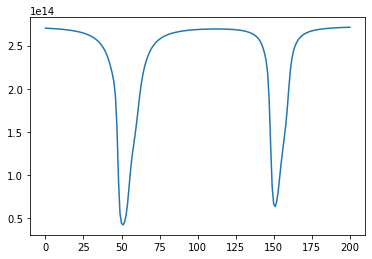

In [24]:
plt.plot(data[0])

In [25]:
data_norm = np.copy(data)

In [26]:
# If you want to normalize wavelength wise (not a good idea imho)

#for l in range(0,201):
#    data_norm[:,l] = (data[:,l] - np.amin(data[:,l])) / (np.amax(data[:,l])-np.amin(data[:,l]))

In [99]:
dmax = np.amax(data)
dmin = np.amin(data)

In [27]:
data_norm[:,:] = (data[:,:] - np.amin(data[:,:])) / (np.amax(data[:,:])-np.amin(data[:,:]))

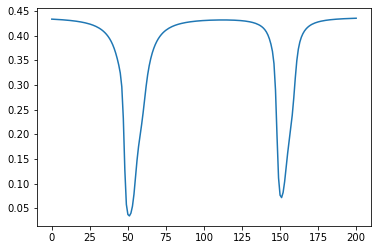

In [28]:
plt.plot(data_norm[0])

In [29]:
del(data)

In [30]:
data_torch = torch.from_numpy(data_norm.astype('float32'))

In [34]:
test_output = model_predict(ae_model,data_torch[:10],cudaoption)

In [35]:
test_output.shape

torch.Size([10, 201])

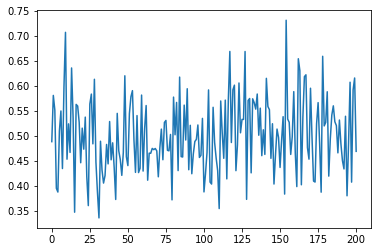

In [36]:
plt.plot(test_output[0].detach().numpy())

In [135]:
## Let's make a function to train:

def compilefit(model, data, nepochs, criterion, cudaoption, lri, output_interval):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri)
    loss_fn = nn.MSELoss()
    
    if cudaoption:
        data = data.to(device)
        
    performance = np.zeros(nepochs)
            
    for i in range(0,nepochs):
        
        optimizer.zero_grad()
        out = model.forward(data)
             
        loss = loss_fn(data,out)
        loss.backward()
        optimizer.step()
        performance[i] = loss.item()
        if i%int(output_interval)==0: print(f' It : {i:3d} - loss : {loss.item():.6f} - residual std : {np.sqrt(loss.item()):.6f}')
    return performance

In [132]:
# Create model again as the above was just testing:
ae_model = make_model(cudaoption, 201, 10)

[INFO] Cuda model: NVIDIA GeForce RTX 3060 Ti
[INFO] Parameters in GPU: True


In [133]:
summary(ae_model,input_size=(1,201))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 80]          16,160
           Sigmoid-2                [-1, 1, 80]               0
            Linear-3                [-1, 1, 40]           3,240
           Sigmoid-4                [-1, 1, 40]               0
            Linear-5                [-1, 1, 10]             410
           Sigmoid-6                [-1, 1, 10]               0
            Linear-7                [-1, 1, 40]             440
           Sigmoid-8                [-1, 1, 40]               0
            Linear-9                [-1, 1, 80]           3,280
          Sigmoid-10                [-1, 1, 80]               0
           Linear-11               [-1, 1, 201]          16,281
          Sigmoid-12               [-1, 1, 201]               0
Total params: 39,811
Trainable params: 39,811
Non-trainable params: 0
---------------------------------

In [138]:
nepochs = 100000

convergence = compilefit(ae_model, data_torch, nepochs, 0, cudaoption, 5E-3, 1000)

 It :   0 - loss : 0.000017 - residual std : 0.004167
 It : 1000 - loss : 0.000017 - residual std : 0.004079
 It : 2000 - loss : 0.000021 - residual std : 0.004616
 It : 3000 - loss : 0.000019 - residual std : 0.004354
 It : 4000 - loss : 0.000021 - residual std : 0.004631
 It : 5000 - loss : 0.000024 - residual std : 0.004930
 It : 6000 - loss : 0.000017 - residual std : 0.004071
 It : 7000 - loss : 0.000030 - residual std : 0.005472
 It : 8000 - loss : 0.000021 - residual std : 0.004584
 It : 9000 - loss : 0.000019 - residual std : 0.004305
 It : 10000 - loss : 0.000015 - residual std : 0.003846
 It : 11000 - loss : 0.000015 - residual std : 0.003846
 It : 12000 - loss : 0.000020 - residual std : 0.004481
 It : 13000 - loss : 0.000015 - residual std : 0.003902
 It : 14000 - loss : 0.000019 - residual std : 0.004306
 It : 15000 - loss : 0.000027 - residual std : 0.005166
 It : 16000 - loss : 0.000014 - residual std : 0.003793
 It : 17000 - loss : 0.000016 - residual std : 0.004044
 It

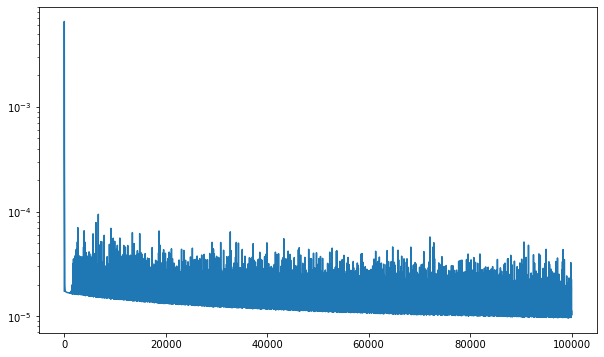

In [139]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence)

In [140]:
test_train = test_output = model_predict(ae_model,data_torch[:10],cudaoption)
test_train.shape

torch.Size([10, 201])

In [141]:
bla = test_train.detach().numpy()

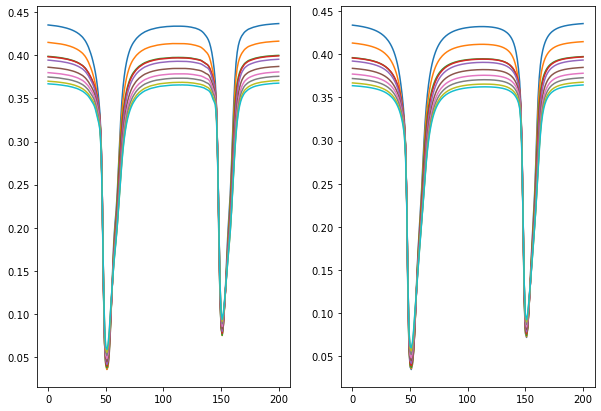

In [142]:
plt.figure(figsize=[10,7])
plt.subplot(121)
for i in range(0,10):
    plt.plot(bla[i])
plt.subplot(122)
for i in range(0,10):
    plt.plot(data_norm[i])



### Here we do some statistical analysis of the "compression"

In [143]:
test_output = model_predict(ae_model,data_torch,cudaoption)

In [144]:
data_reconstructed = test_output.detach().numpy()

In [145]:
# de-normalize

data_reconstructed  = data_reconstructed * (dmax-dmin) + dmin

In [146]:
noise = np.mean(data[:,0]) * 7E-3

residual = (data - data_reconstructed)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 201
print (np.mean(chisq))
print (np.median(chisq))

82944
1.614636370177397
1.3442587020718462


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00, 9.000e+00, 1.600e+01, 8.500e+01, 2.300e+02, 4.650e+02,
        1.329e+03, 2.713e+03, 3.749e+03, 4.239e+03, 4.819e+03, 4.843e+03,
        4.381e+03, 4.158e+03, 4.234e+03, 4.402e+03, 4.377e+03, 4.130e+03,
        3.906e+03, 3.354e+03, 3.059e+03, 2.640e+03, 2.110e+03, 1.819e+03,
        1.596e+03, 1.384e+03, 1.242e+03, 1.101e+03, 1.003e+03, 8.330e+02,
        9.230e+02, 7.400e+02, 6.000e+02, 5.630e+02, 5.150e+02, 4.320e+02,
        3.980e+02, 3.340e+02, 3.310e+02, 3.220e+02, 2.580e+02, 2.320e+02,
        2.310e+02, 2.230e+02]),
 array([0.  , 0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.48, 0.54, 0.6 ,
        0.66, 0.72, 0.78, 0.84, 0.9 , 0.96, 1.02, 1.08, 1.14, 1.2 , 1.26,
        1.32, 1.38, 1.44, 1.5 , 1.56, 1.62, 1.68, 1.74, 1.8 , 1.86, 1.92,
        1.98, 2.04, 2.1 , 2.16, 2.22, 2.28, 2.34, 2.4 , 2.46, 2.52, 2.58,
        2.64, 2.7 , 2.76, 2.82, 2.88, 2.94, 3.  ]),
 <BarContainer object of 50 

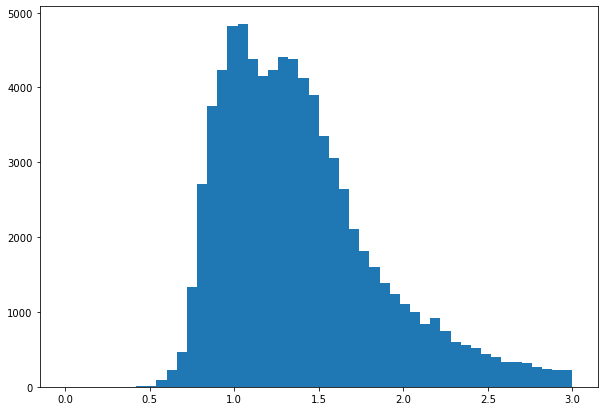

In [147]:
plt.figure(figsize=[10,7])
plt.hist(chisq,bins=50,range=[0,3])

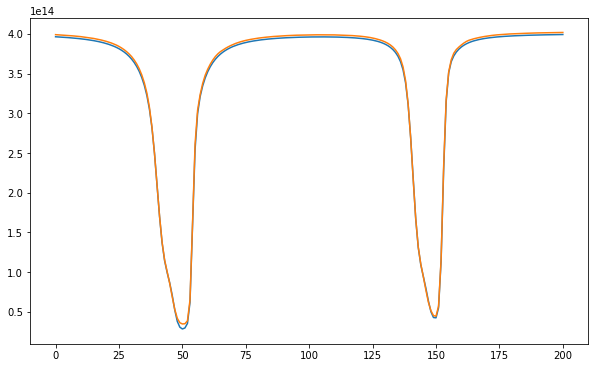

In [148]:
# Example plots 

i = 33337

plt.figure(figsize=[10,6])
plt.plot(data[i])
plt.plot(data_reconstructed[i])